In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cpu


In [3]:
data_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/data/processed/multimodal_unaligned_data.pkl')
with open(data_path, 'rb') as f:
    data = pickle.load(f)

patients = data['patients']
train_ids = data['train_ids']
val_ids = data['val_ids']
test_ids = data['test_ids']

print(f"Total patients: {len(patients)}")
print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

sample = patients[train_ids[0]]
print(f"\nSample patient structure:")
print(f"  MGX: {len(sample['mgx']['timepoints'])} timepoints, {sample['mgx']['pca_coords'].shape}")
print(f"  MTX: {len(sample['mtx']['timepoints'])} timepoints, {sample['mtx']['pca_coords'].shape}")

Total patients: 100
Train: 70, Val: 15, Test: 15

Sample patient structure:
  MGX: 18 timepoints, (18, 10)
  MTX: 10 timepoints, (10, 10)


In [4]:
class DualModalityDataset(Dataset):
    def __init__(self, patient_dict, patient_ids):
        self.patient_ids = patient_ids
        self.data = []
        
        for pid in patient_ids:
            patient_data = patient_dict[pid]
            
            mgx_times = np.array(patient_data['mgx']['timepoints'], dtype=np.float32)
            mgx_coords = np.array(patient_data['mgx']['pca_coords'], dtype=np.float32)
            
            mtx_times = np.array(patient_data['mtx']['timepoints'], dtype=np.float32)
            mtx_coords = np.array(patient_data['mtx']['pca_coords'], dtype=np.float32)
            
            # Normalize times to [0, 1]
            all_times = np.concatenate([mgx_times, mtx_times])
            t_min, t_max = all_times.min(), all_times.max()
            
            mgx_times_norm = (mgx_times - t_min) / (t_max - t_min + 1e-6)
            mtx_times_norm = (mtx_times - t_min) / (t_max - t_min + 1e-6)
            
            self.data.append({
                'patient_id': pid,
                'mgx_timepoints': torch.from_numpy(mgx_times),
                'mgx_timepoints_norm': torch.from_numpy(mgx_times_norm),
                'mgx_observations': torch.from_numpy(mgx_coords),
                'mtx_timepoints': torch.from_numpy(mtx_times),
                'mtx_timepoints_norm': torch.from_numpy(mtx_times_norm),
                'mtx_observations': torch.from_numpy(mtx_coords),
                'diagnosis': patient_data['diagnosis'],
                't_min': t_min,
                't_max': t_max
            })
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = DualModalityDataset(patients, train_ids)
val_dataset = DualModalityDataset(patients, val_ids)
test_dataset = DualModalityDataset(patients, test_ids)

print(f"Datasets created: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

Datasets created: 70 train, 15 val, 15 test


## model architecture

In [5]:
class MGXEncoder(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=32, latent_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class MTXEncoder(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=32, latent_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class MGXDecoder(nn.Module):
    def __init__(self, latent_dim=3, hidden_dim=32, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, z):
        return self.net(z)

class MTXDecoder(nn.Module):
    def __init__(self, latent_dim=3, hidden_dim=32, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, z):
        return self.net(z)

class DualEncoderModel(nn.Module):
    def __init__(self, obs_dim=10, latent_dim=3, hidden_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.mgx_encoder = MGXEncoder(obs_dim, hidden_dim, latent_dim)
        self.mtx_encoder = MTXEncoder(obs_dim, hidden_dim, latent_dim)
        self.mgx_decoder = MGXDecoder(latent_dim, hidden_dim, obs_dim)
        self.mtx_decoder = MTXDecoder(latent_dim, hidden_dim, obs_dim)
    
    def forward(self, mgx_obs, mtx_obs):
        mgx_latent = self.mgx_encoder(mgx_obs)
        mtx_latent = self.mtx_encoder(mtx_obs)
        
        mgx_recon = self.mgx_decoder(mgx_latent)
        mtx_recon = self.mtx_decoder(mtx_latent)
        
        return mgx_recon, mtx_recon, mgx_latent, mtx_latent

LATENT_DIM = 3
HIDDEN_DIM = 32
OBS_DIM = 10

model = DualEncoderModel(OBS_DIM, LATENT_DIM, HIDDEN_DIM).to(device)
print(f"\nModel initialized with {LATENT_DIM}D shared latent space")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")


Model initialized with 3D shared latent space
Total parameters: 1818


## training

In [6]:
def compute_loss(model, batch):
    mgx_obs = batch['mgx_observations'].to(device)
    mtx_obs = batch['mtx_observations'].to(device)
    
    mgx_recon, mtx_recon, mgx_latent, mtx_latent = model(mgx_obs, mtx_obs)
    
    mgx_recon_loss = nn.functional.mse_loss(mgx_recon, mgx_obs)
    mtx_recon_loss = nn.functional.mse_loss(mtx_recon, mtx_obs)
    
    alignment_loss = nn.functional.mse_loss(mgx_latent.mean(dim=0), mtx_latent.mean(dim=0))
    
    reg_loss = 0.01 * (torch.mean(mgx_latent ** 2) + torch.mean(mtx_latent ** 2))
    
    total_loss = mgx_recon_loss + mtx_recon_loss + 0.1 * alignment_loss + reg_loss
    
    return total_loss, mgx_recon_loss, mtx_recon_loss, alignment_loss, reg_loss

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [7]:
def train_epoch(model, dataset, optimizer):
    model.train()
    total_loss = 0
    mgx_recon_total = 0
    mtx_recon_total = 0
    
    for batch in dataset:
        optimizer.zero_grad()
        loss, mgx_recon, mtx_recon, align, reg = compute_loss(model, batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        mgx_recon_total += mgx_recon.item()
        mtx_recon_total += mtx_recon.item()
    
    n = len(dataset)
    return total_loss / n, mgx_recon_total / n, mtx_recon_total / n

def validate(model, dataset):
    model.eval()
    total_loss = 0
    mgx_recon_total = 0
    mtx_recon_total = 0
    
    with torch.no_grad():
        for batch in dataset:
            loss, mgx_recon, mtx_recon, align, reg = compute_loss(model, batch)
            total_loss += loss.item()
            mgx_recon_total += mgx_recon.item()
            mtx_recon_total += mtx_recon.item()
    
    n = len(dataset)
    return total_loss / n, mgx_recon_total / n, mtx_recon_total / n

NUM_EPOCHS = 100
PATIENCE = 20

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

output_dir = Path('../results/dual_encoder_model')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Starting training for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    train_loss, train_mgx, train_mtx = train_epoch(model, train_dataset, optimizer)
    val_loss, val_mgx, val_mtx = validate(model, val_dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train - Total: {train_loss:.4f}, MGX: {train_mgx:.4f}, MTX: {train_mtx:.4f}")
        print(f"  Val   - Total: {val_loss:.4f}, MGX: {val_mgx:.4f}, MTX: {val_mtx:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, output_dir / 'best_model.pt')
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\nTraining complete. Best val loss: {best_val_loss:.4f}")

Starting training for 100 epochs...

Epoch 10/100
  Train - Total: 39.1728, MGX: 12.7624, MTX: 24.2682
  Val   - Total: 41.2576, MGX: 18.3217, MTX: 20.9285
  LR: 0.001000
Epoch 20/100
  Train - Total: 33.3888, MGX: 11.1075, MTX: 20.7004
  Val   - Total: 37.3896, MGX: 17.3978, MTX: 18.6253
  LR: 0.001000
Epoch 30/100
  Train - Total: 31.1116, MGX: 10.4791, MTX: 19.3642
  Val   - Total: 36.6992, MGX: 17.1167, MTX: 18.4697
  LR: 0.001000
Epoch 40/100
  Train - Total: 29.8495, MGX: 10.0704, MTX: 18.7039
  Val   - Total: 36.5416, MGX: 16.9730, MTX: 18.6041
  LR: 0.001000
Epoch 50/100
  Train - Total: 29.0081, MGX: 9.7705, MTX: 18.2893
  Val   - Total: 36.3636, MGX: 16.7980, MTX: 18.7142
  LR: 0.001000
Epoch 60/100
  Train - Total: 28.3680, MGX: 9.5369, MTX: 17.9702
  Val   - Total: 36.1327, MGX: 16.6297, MTX: 18.7219
  LR: 0.001000
Epoch 70/100
  Train - Total: 27.8400, MGX: 9.3559, MTX: 17.6883
  Val   - Total: 35.9220, MGX: 16.4870, MTX: 18.7120
  LR: 0.001000
Epoch 80/100
  Train - Total

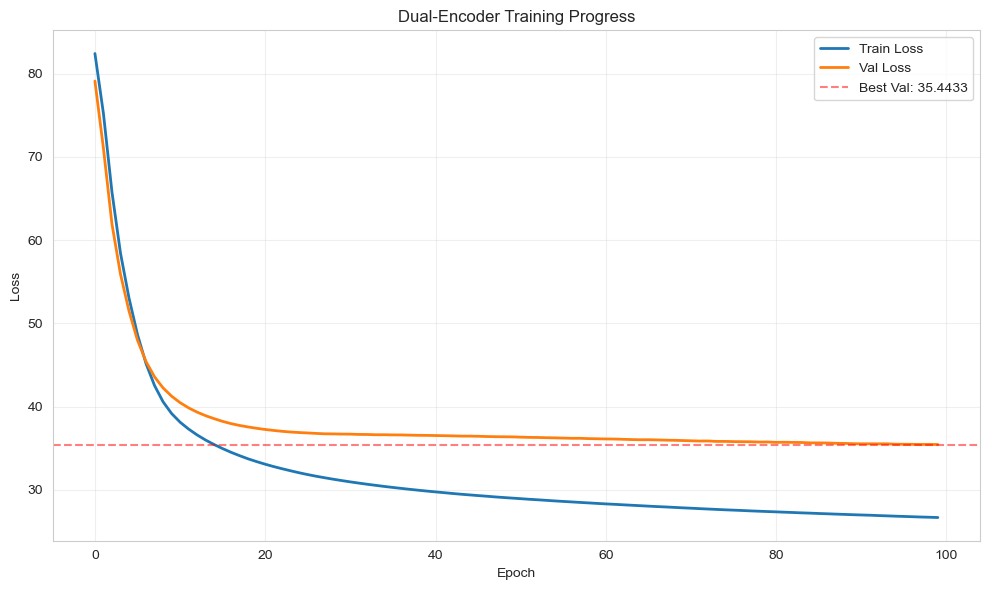

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(val_losses, label='Val Loss', linewidth=2)
ax.axhline(best_val_loss, color='red', linestyle='--', alpha=0.5, label=f'Best Val: {best_val_loss:.4f}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Dual-Encoder Training Progress')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'training_curves.png', dpi=150)
plt.show()

## extract latent codes

In [10]:
checkpoint = torch.load(output_dir / 'best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def extract_latent_codes(model, dataset):
    latent_data = {}
    
    with torch.no_grad():
        for batch in dataset:
            patient_id = batch['patient_id']
            
            mgx_obs = batch['mgx_observations'].to(device)
            mtx_obs = batch['mtx_observations'].to(device)
            
            mgx_latent = model.mgx_encoder(mgx_obs).cpu().numpy()
            mtx_latent = model.mtx_encoder(mtx_obs).cpu().numpy()
            
            mgx_times = batch['mgx_timepoints'].cpu().numpy()
            mtx_times = batch['mtx_timepoints'].cpu().numpy()
            
            # Combine latent codes from both modalities
            all_times = np.concatenate([mgx_times, mtx_times])
            all_latent = np.vstack([mgx_latent, mtx_latent])
            
            # Sort by time
            sorted_idx = np.argsort(all_times)
            
            latent_data[patient_id] = {
                'timepoints': all_times[sorted_idx],
                'latent_codes': all_latent[sorted_idx],
                'mgx_timepoints': mgx_times,
                'mtx_timepoints': mtx_times,
                'mgx_latent': mgx_latent,
                'mtx_latent': mtx_latent,
                'diagnosis': batch['diagnosis']
            }
    
    return latent_data

print("Extracting latent codes...")
train_latents = extract_latent_codes(model, train_dataset)
val_latents = extract_latent_codes(model, val_dataset)
test_latents = extract_latent_codes(model, test_dataset)

print(f"Extracted: {len(train_latents)} train, {len(val_latents)} val, {len(test_latents)} test")

Extracting latent codes...
Extracted: 70 train, 15 val, 15 test


## fit GP trajectories

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

def fit_gp_to_latents(latent_dict):
    gp_trajectories = {}
    kernel = C(1.0) * RBF(length_scale=5.0) + WhiteKernel(noise_level=0.1)
    
    for patient_id, patient_data in latent_dict.items():
        timepoints = patient_data['timepoints'].reshape(-1, 1)
        z = patient_data['latent_codes']
        
        if len(timepoints) < 2:
            continue
        
        gps = []
        for dim in range(z.shape[1]):
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
            gp.fit(timepoints, z[:, dim])
            gps.append(gp)
        
        t_min, t_max = timepoints.min(), timepoints.max()
        dense_times = np.arange(t_min, t_max + 1, 1.0).reshape(-1, 1)
        
        z_smooth = np.column_stack([gp.predict(dense_times) for gp in gps])
        
        gp_trajectories[patient_id] = {
            'timepoints': dense_times.flatten(),
            'latent_trajectory': z_smooth,
            'observed_timepoints': timepoints.flatten(),
            'observed_latent': z,
            'diagnosis': patient_data['diagnosis']
        }
    
    return gp_trajectories

print("Fitting GPs to latent codes...")
train_gp = fit_gp_to_latents(train_latents)
val_gp = fit_gp_to_latents(val_latents)
test_gp = fit_gp_to_latents(test_latents)
print(f"GP trajectories created: {len(train_gp)} train, {len(val_gp)} val, {len(test_gp)} test")

Fitting GPs to latent codes...
GP trajectories created: 70 train, 15 val, 15 test
